In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import os

os.listdir()

In [ ]:
import pandas as pd

df = pd.read_excel("data_clean.xlsx")

Saving data_clean.xlsx to data_clean (6).xlsx


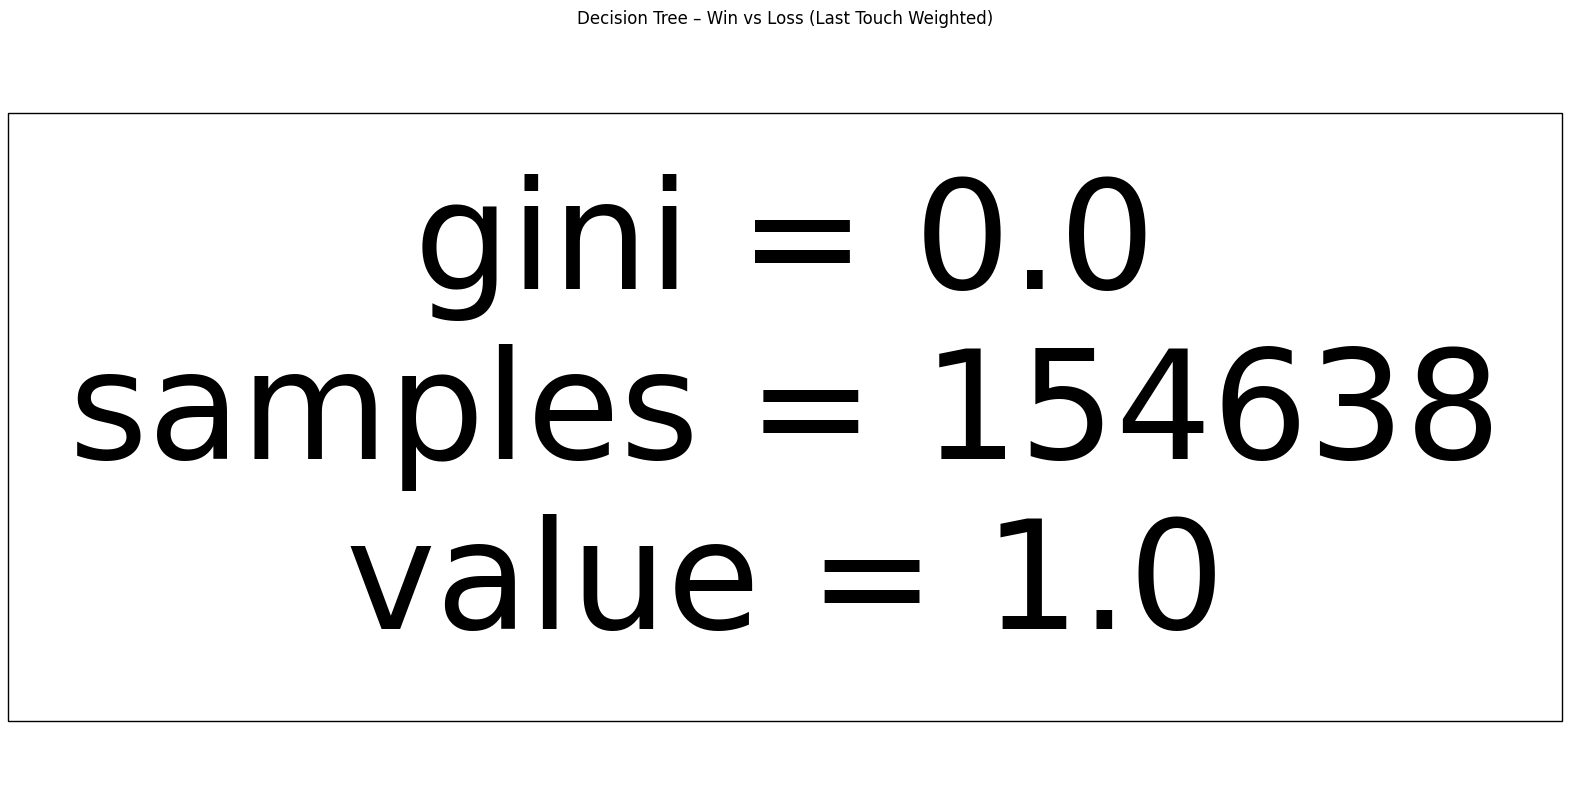

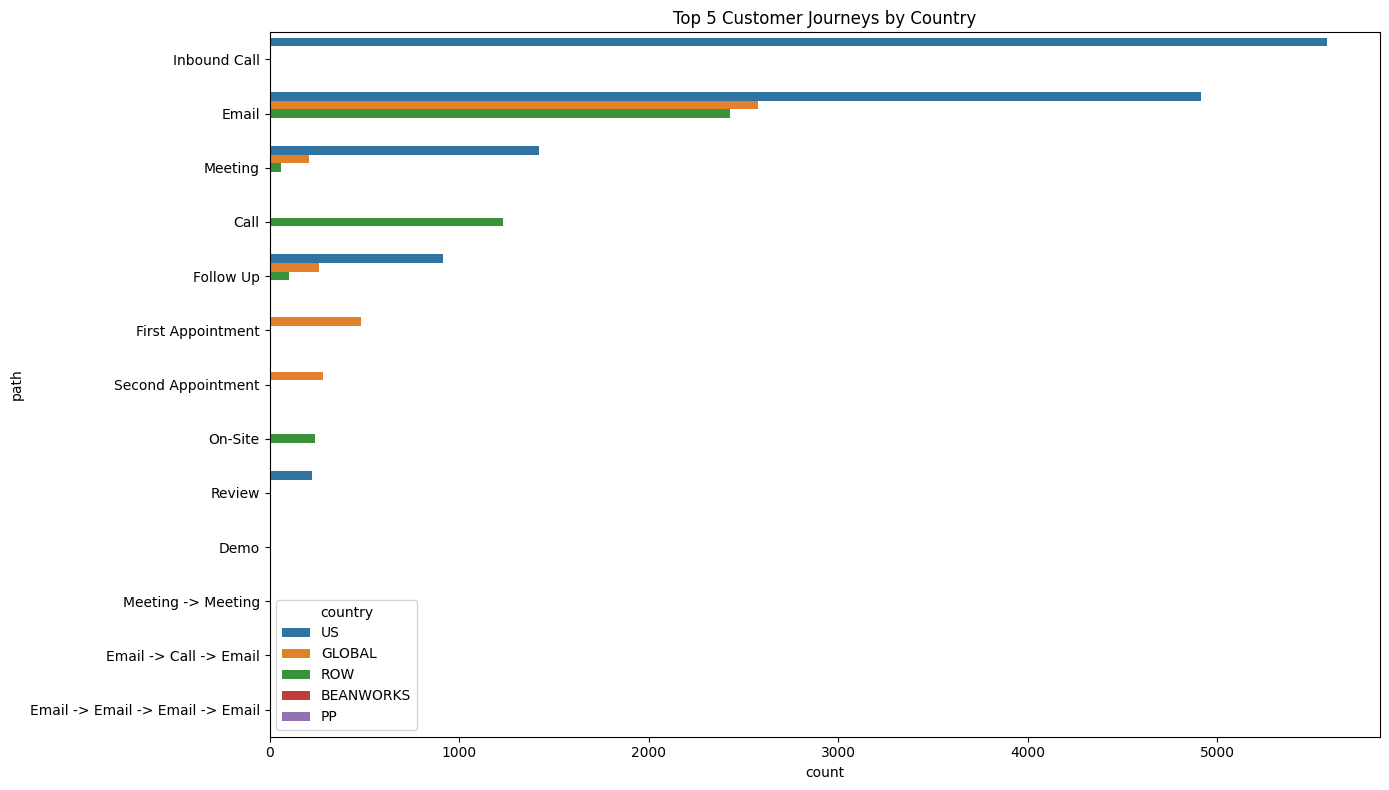

Top 4 Actions by Country + Solution:
Series([], Name: action_weight, dtype: float64)

After New Action:
types
Outbound Email    1.0
Name: action_weight, dtype: float64
Predicted Outcome: Loss

Win / Loss Prediction:
Loss


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OrdinalEncoder was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OrdinalEncoder was fitted with feature names



In [8]:
!pip install pandas scikit-learn matplotlib seaborn plotly

# ===============================
# Imports
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder
from google.colab import files


uploaded = files.upload()
df = pd.read_excel("data_clean.xlsx")


for col in ['types', 'opportunity_stage', 'SourceSystem']:
    df[col] = df[col].fillna('unknown')

df['is_lead'] = pd.to_numeric(df['is_lead'], errors='coerce').fillna(0).astype(int)

df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
df['activity_date'] = df['activity_date'].fillna(pd.Timestamp('1900-01-01'))

# Country & Solution
df['country'] = df['SourceSystem'].str.split('_').str[-1]
df['solution'] = df['SourceSystem'].str.split('_').str[0]

WIN_STAGES = ['Closed Won', 'Won']
df['win_loss'] = df['opportunity_stage'].apply(
    lambda x: 1 if x in WIN_STAGES else 0
)


df = df.sort_values('activity_date')

df['action_weight'] = (
    df.groupby('who_id')['activity_date']
    .rank(method='first', ascending=False)
)

df['action_weight'] = 1 / df['action_weight']
df['action_weight'] = df['action_weight'].fillna(1.0)


encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(df[['types', 'opportunity_stage']])
df[['types_encoded', 'stage_encoded']] = encoder.transform(
    df[['types', 'opportunity_stage']]
)


# Decision Tree Training (Weighted)

X = df[['types_encoded', 'is_lead']]
y = df['win_loss']

clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X, y, sample_weight=df['action_weight'])


plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=['types_encoded', 'is_lead'],
    class_names=['Loss', 'Win'],
    filled=True
)
plt.title("Decision Tree – Win vs Loss (Last Touch Weighted)")
plt.show()

=
def calculate_new_weight(base_weight, last_touch_weight):
    return base_weight * (1 - last_touch_weight)


# Top 4 Actions (Weighted)

def get_top_actions(df, country=None, solution=None):
    subset = df.copy()
    if country:
        subset = subset[subset['country'] == country]
    if solution:
        subset = subset[subset['solution'] == solution]

    return (
        subset.groupby('types')['action_weight']
        .sum()
        .sort_values(ascending=False)
        .head(4)
    )

# Predict Win / Loss

def predict_win_or_loss(action_type, is_lead):
    encoded = encoder.transform([[action_type, 'unknown']])
    action_encoded = encoded[0][0]

    X_input = pd.DataFrame(
        [[action_encoded, is_lead]],
        columns=['types_encoded', 'is_lead']
    )

    return "Win" if clf.predict(X_input)[0] == 1 else "Loss"

# Update Weights & Retrain
def update_weights_and_retrain(new_action, country, solution, is_lead=0):
    global df

    subset = df[(df['country'] == country) & (df['solution'] == solution)]

    last_touch_weight = subset.iloc[-1]['action_weight'] if not subset.empty else 0
    new_weight = calculate_new_weight(1.0, last_touch_weight)

    new_row = pd.DataFrame({
        'types': [new_action],
        'country': [country],
        'solution': [solution],
        'SourceSystem': [f"{solution}_{country}"],
        'is_lead': [is_lead],
        'activity_date': [pd.Timestamp.now()],
        'opportunity_stage': ['unknown'],
        'win_loss': [0],
        'action_weight': [new_weight]
    })

    df = pd.concat([df, new_row], ignore_index=True)

    X = df[['types_encoded', 'is_lead']]
    y = df['win_loss']
    clf.fit(X, y, sample_weight=df['action_weight'])

    return (
        get_top_actions(df, country, solution),
        predict_win_or_loss(new_action, is_lead)
    )

# Customer Journey (Top 5 Paths)
df['path'] = df.groupby(
    ['country', 'solution', 'who_id']
)['types'].transform(lambda x: ' -> '.join(x))


df['path_length'] = df['path'].apply(lambda x: len(str(x).split(' -> ')) if pd.notna(x) else 0)

top_paths = (
    df.groupby(['country', 'solution', 'path', 'path_length'])
    .size()
    .reset_index(name='count')
    .sort_values(['path_length', 'count'], ascending=[True, False])
    .groupby(['country', 'solution'])
    .head(5)
)



plt.figure(figsize=(14, 8))
sns.barplot(data=top_paths, x='count', y='path', hue='country')
plt.title("Top 5 Customer Journeys by Country")
plt.tight_layout()
plt.show()

def plot_actions_plotly(df, country):
    actions = (
        df[df['country'] == country]
        .groupby('types')['action_weight']
        .sum()
        .reset_index()
    )

    fig = px.bar(
        actions,
        x='types',
        y='action_weight',
        title=f"Top Actions in {country} (Weighted)",
        color='types'
    )
    fig.show()

plot_actions_plotly(df, 'US')


print("Top 4 Actions by Country + Solution:")
print(get_top_actions(df, 'US', 'CRM'))

top_actions, outcome = update_weights_and_retrain(
    'Outbound Email', 'US', 'CRM', is_lead=1
)

print("\nAfter New Action:")
print(top_actions)
print("Predicted Outcome:", outcome)

print("\nWin / Loss Prediction:")
print(predict_win_or_loss('Inbound Call', 1))
